# Bayesian Inference with information content model check for Langevin Equations

The langevin equation is given by 

$$ \boxed{\frac{d\hat{x}(t)}{dt} = \mu(\hat{x}) f + k_BT\frac{\partial\mu(\hat{x})}{\partial t} + \sqrt{2Dk_BT\mu(\hat{x})}\hat{\xi}(t)} $$

where $$ \boxed{\mu(\hat{x}) = D_0 |\hat{x}|^\alpha} $$

### The Euler Maruyuma Integrator

This is the integrator for the langevin eqution given in the physics paper

$$ \boxed{x(t+dt) = x(t) +D_0  |x(t)|^\alpha dt + k_B T \left(\alpha D_0 |x(t)|^{\alpha -1} \dfrac{x(t)}{|x(t)|}\right) dt+\sqrt{2D_0 k_B T |x(t)|^\alpha dt}\hat{N}(t)} $$


In [47]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from numba import jit

In [48]:
D_0 = 0.2
x_0 = 50
MU = 0.1
t_0 = 0
ALPHA_1 = 1
F_L = [0, -0.1, -0.2, -0.3]
# F_L = [100]
k_BT =1

In [49]:
@jit
def Model(num,t_end,F,D,ALPHA):
    y = np.zeros(num)
    y[0] = x_0
    DT = (t_end-t_0)/num
    t = np.arange(t_0, t_end ,DT)
    for i in range(0,num-1):
        y[i+1] = y[i] + D * (np.abs(y[i])**ALPHA) * F * DT + k_BT * (ALPHA * D * ((np.abs(y[i])**(ALPHA-1)*(y[i]/(np.abs(y[i]))))))* DT+ np.sqrt(2 * D * k_BT * (np.abs(y[i])**ALPHA) *  DT) * np.random.normal(0,1)
        
        # y[i+1] = np.round(y[i] + D * (np.abs(y[i])**ALPHA) * F * DT + k_BT * (ALPHA * D * ((np.abs(y[i])**(ALPHA-1)*(y[i]/(np.abs(y[i]))))))* DT+ np.sqrt(2 * D * k_BT * (np.abs(y[i])**ALPHA) *  DT) * np.random.normal(0,1),3)
    return t, y    

In [56]:
@jit
def Modelprocess_sim(num,t_end, ALPH, D):
    y = np.zeros(num)
    y[0] = x_0
    DT = (t_end-t_0)/num
    t = np.arange(t_0, t_end ,DT)
    for i in range(0,num-1):
        y[i+1] = y[i] + D * (np.abs(y[i])**ALPH) * MU * DT + np.sqrt(2 * D * k_BT * MU *  DT) * np.random.normal(0,1)
        
        # y[i+1] = np.round(y[i] + D * (np.abs(y[i])**ALPHA) * F * DT + k_BT * (ALPHA * D * ((np.abs(y[i])**(ALPHA-1)*(y[i]/(np.abs(y[i]))))))* DT+ np.sqrt(2 * D * k_BT * (np.abs(y[i])**ALPHA) *  DT) * np.random.normal(0,1),3)
    return t, y

## Clean Models

The Models with measurement noise zero

### $M_{free}$ Model
This is the model with zero force $f$, where $f=0$

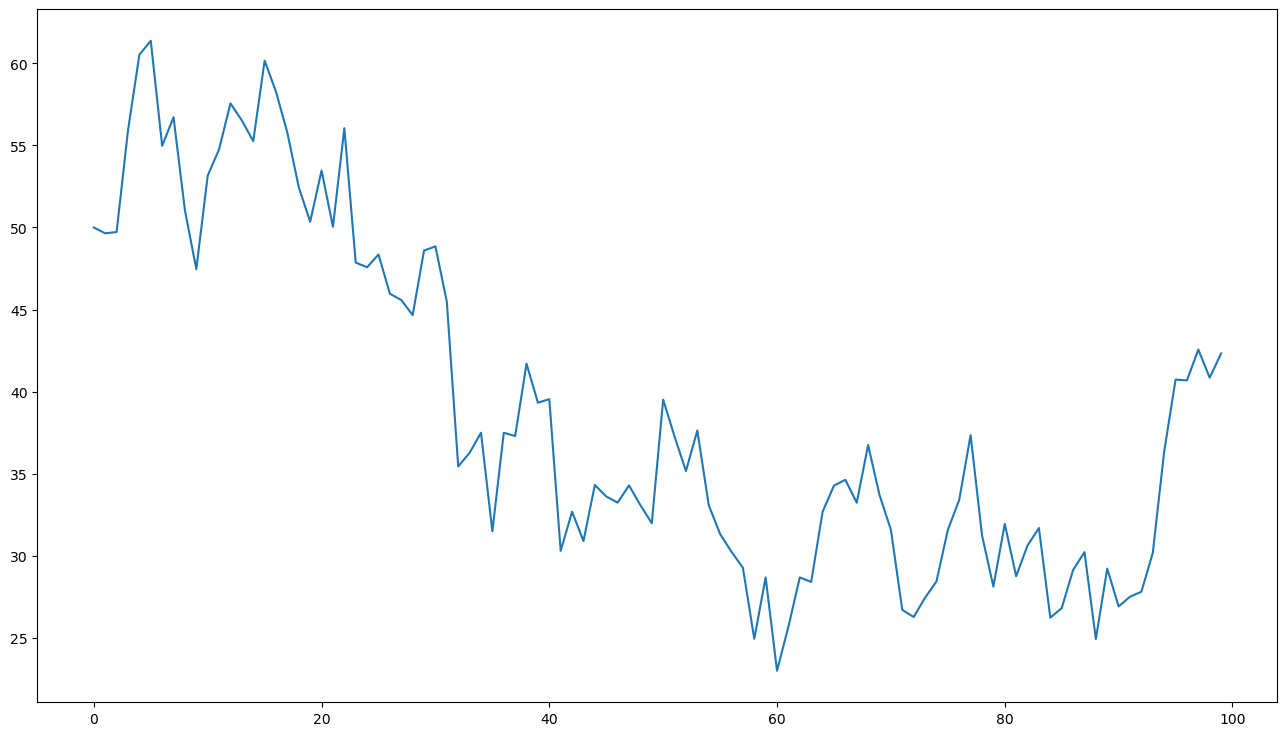

In [51]:
N = 1000
n = 100
t_e = 100
n_stamp = 500
t_sample,p_sample = Model(n,t_e,F_L[0],D_0,ALPHA_1)
DT = t_sample[1] - t_sample[0]
fig,axes = plt.subplots(1,1,figsize=(16,9))
axes.plot(t_sample,p_sample)    

### $M_{pull}$ Model
This is the model with non-zero $f$, where $f=-0.3$

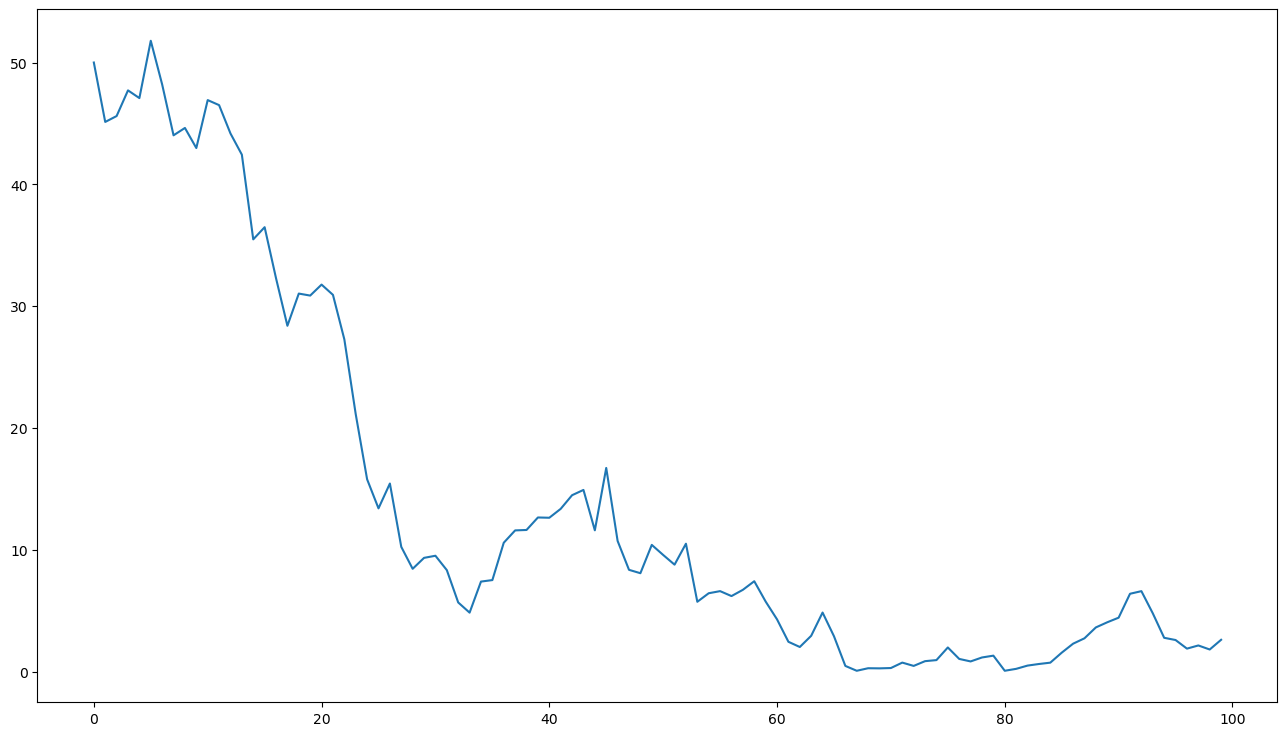

In [52]:
t_sample2,p_sample2 = Model(n,t_e, F_L[3],D_0,ALPHA_1)
fig,axes = plt.subplots(1,1,figsize=(16,9))
axes.plot(t_sample2,p_sample2)    

## Probability distribution at a time stamp for different applied forces

In [53]:
N = 100000
nt_stamp = 50
t_stamp = 0
L = len(F_L)
p_dist_free = np.zeros(N)
p_dist = np.zeros((L,N))
for i in range(0,L):
    for j in range(0,N):
        t_dist, x_dist = Model(n, t_e, F_L[i],D_0,ALPHA_1)
        t_stamp = t_dist[nt_stamp]
        p_dist[i,j] = x_dist[nt_stamp]

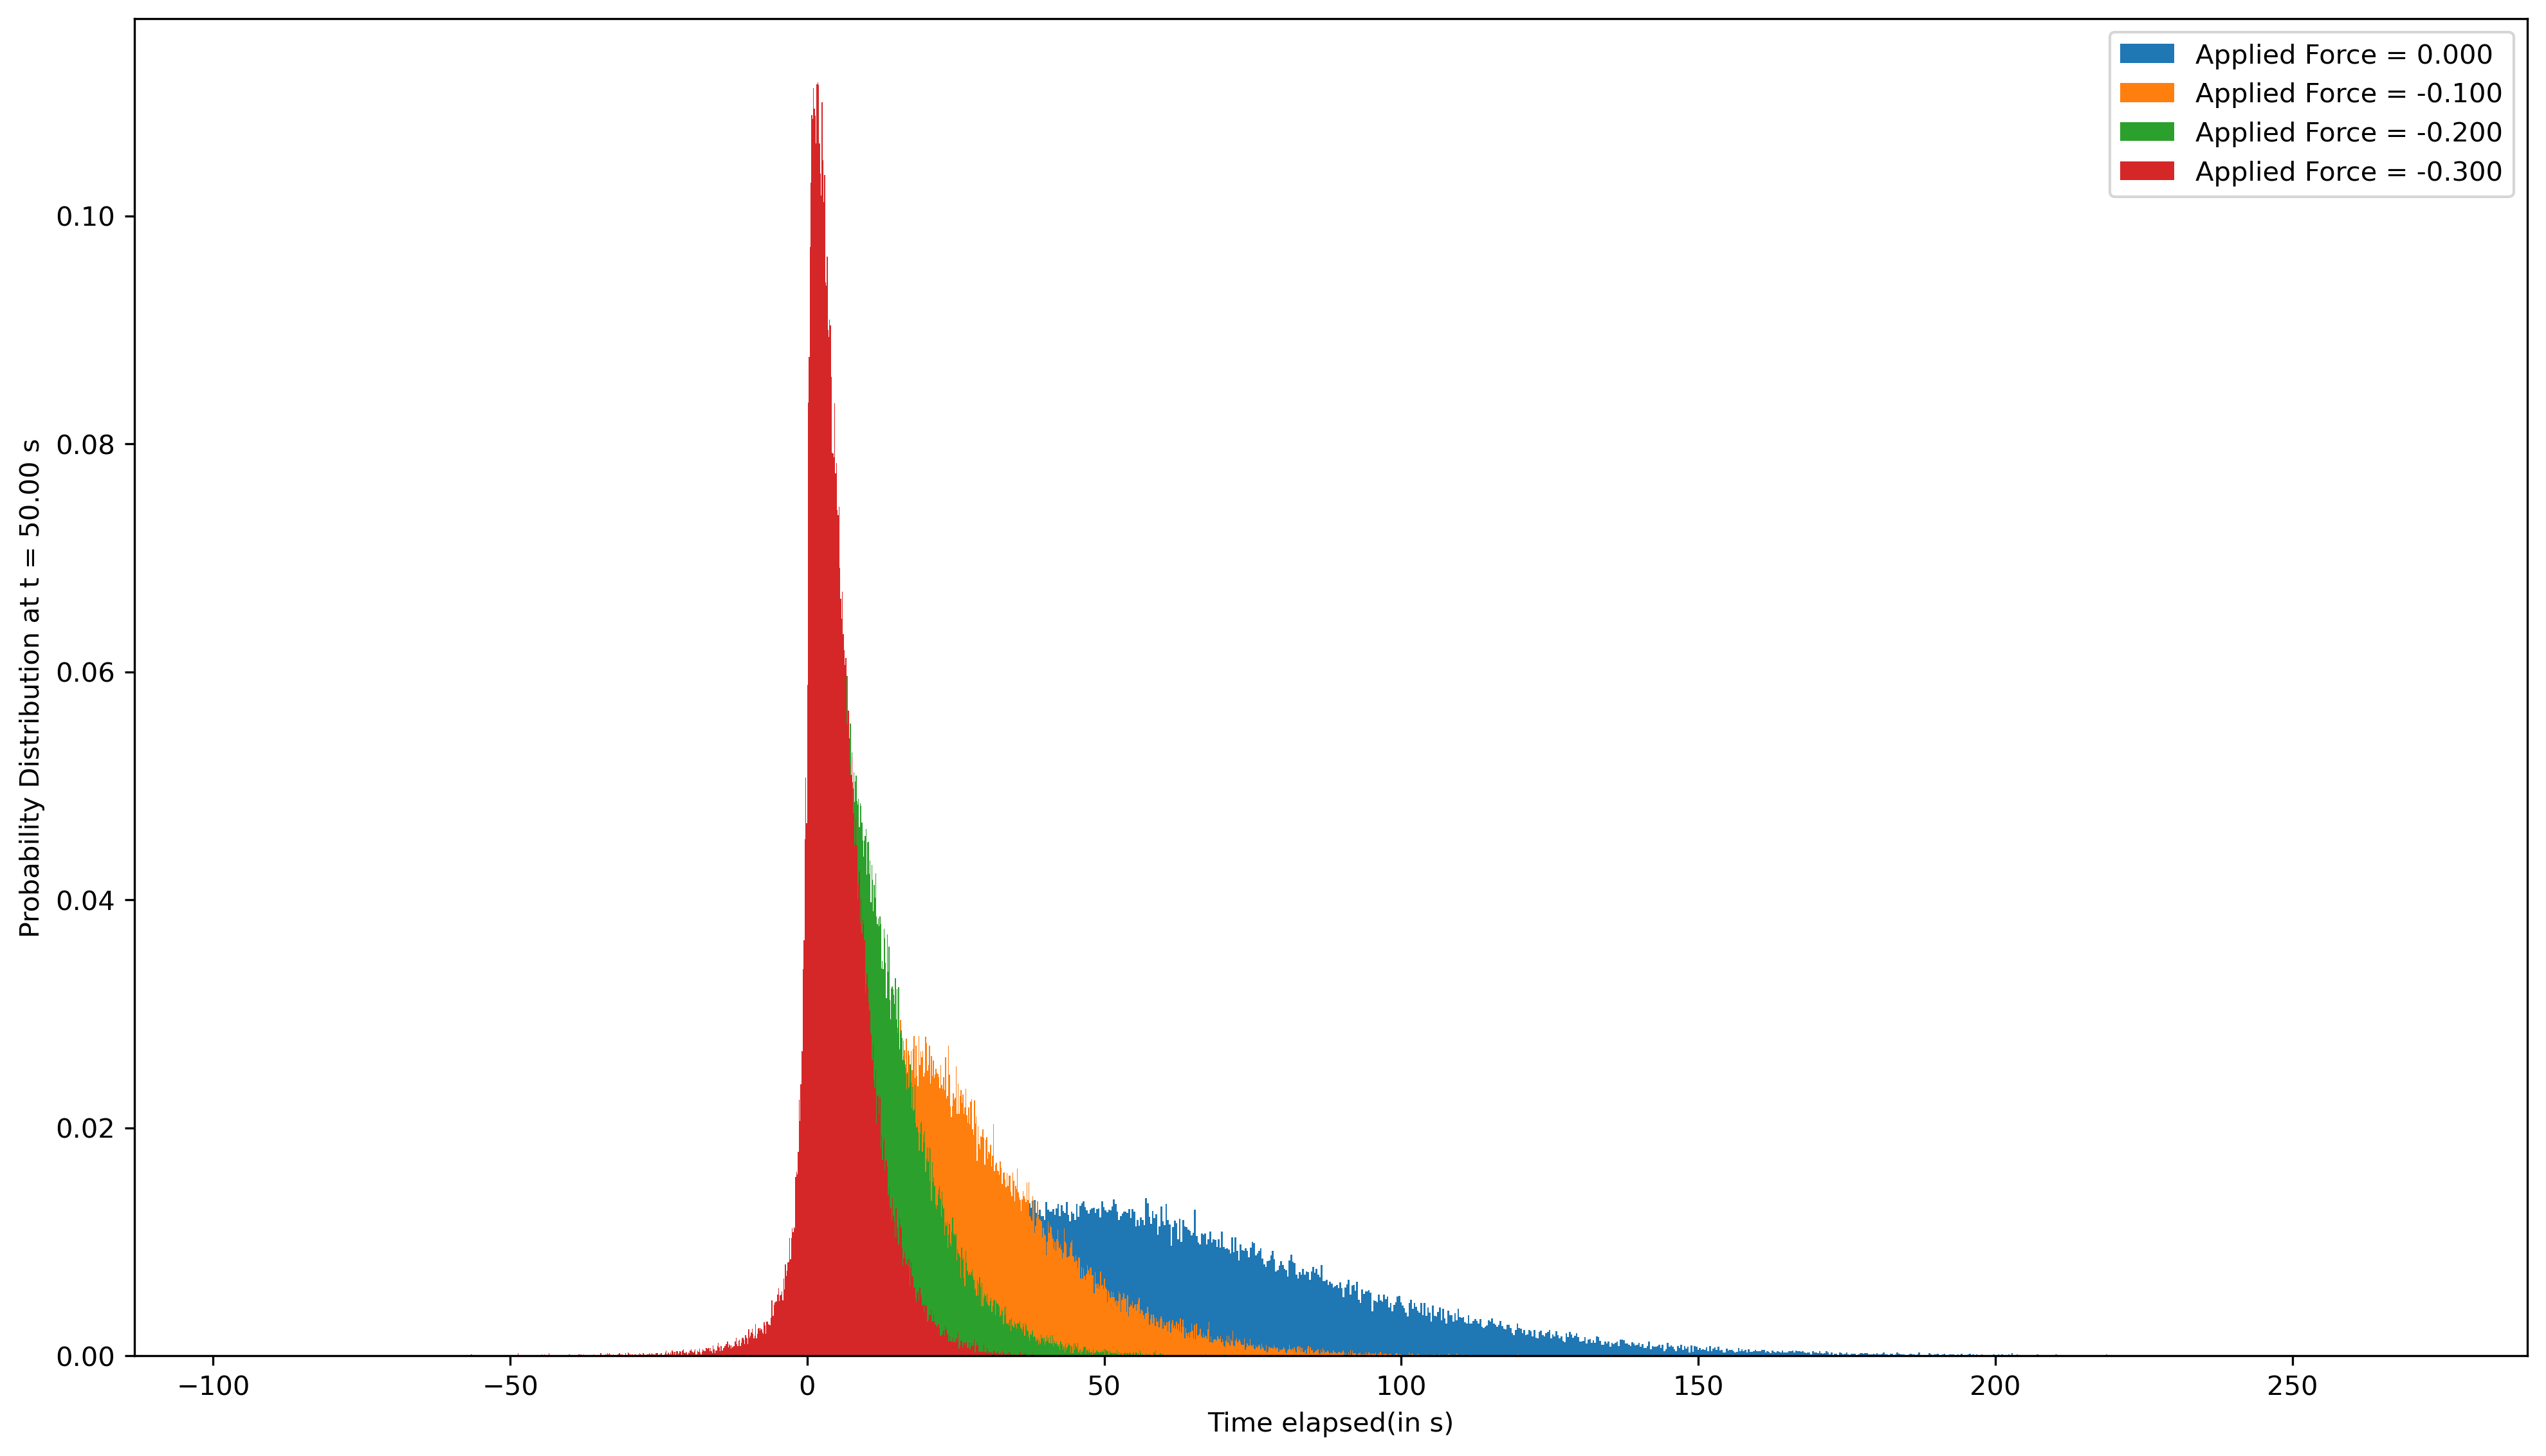

In [54]:
fig,axes = plt.subplots(1,1,figsize=(16,9),dpi=300)
# axes.hist(p_dist_free, bins = 1000, density = True);
# axes.hist(p_dist_pull, bins = 1000, density = True);
for i in range(0,L):
    axes.hist(p_dist[i], bins = 1000, density = True, label = f"Applied Force = %.3f"%F_L[i]);

axes.set_xlabel("Time elapsed(in s)");
axes.set_ylabel("Probability Distribution at t = %.2f s"%t_stamp);
axes.legend()

## Ignore Subsection

### Start Ignoring Cells

In [59]:
ALPHA_2 = [1]

N = 100000
nt_stamp = 50
t_stamp = 0
A = len(ALPHA_2)
p_dist = np.zeros((A,N))
for i in range(0,A):
    for j in range(0,N):
        t_dist, x_dist = Modelprocess_sim(n,t_e,ALPHA_2[i],D_0)
        t_stamp = t_dist[nt_stamp]
        p_dist[i,j] = x_dist[nt_stamp]

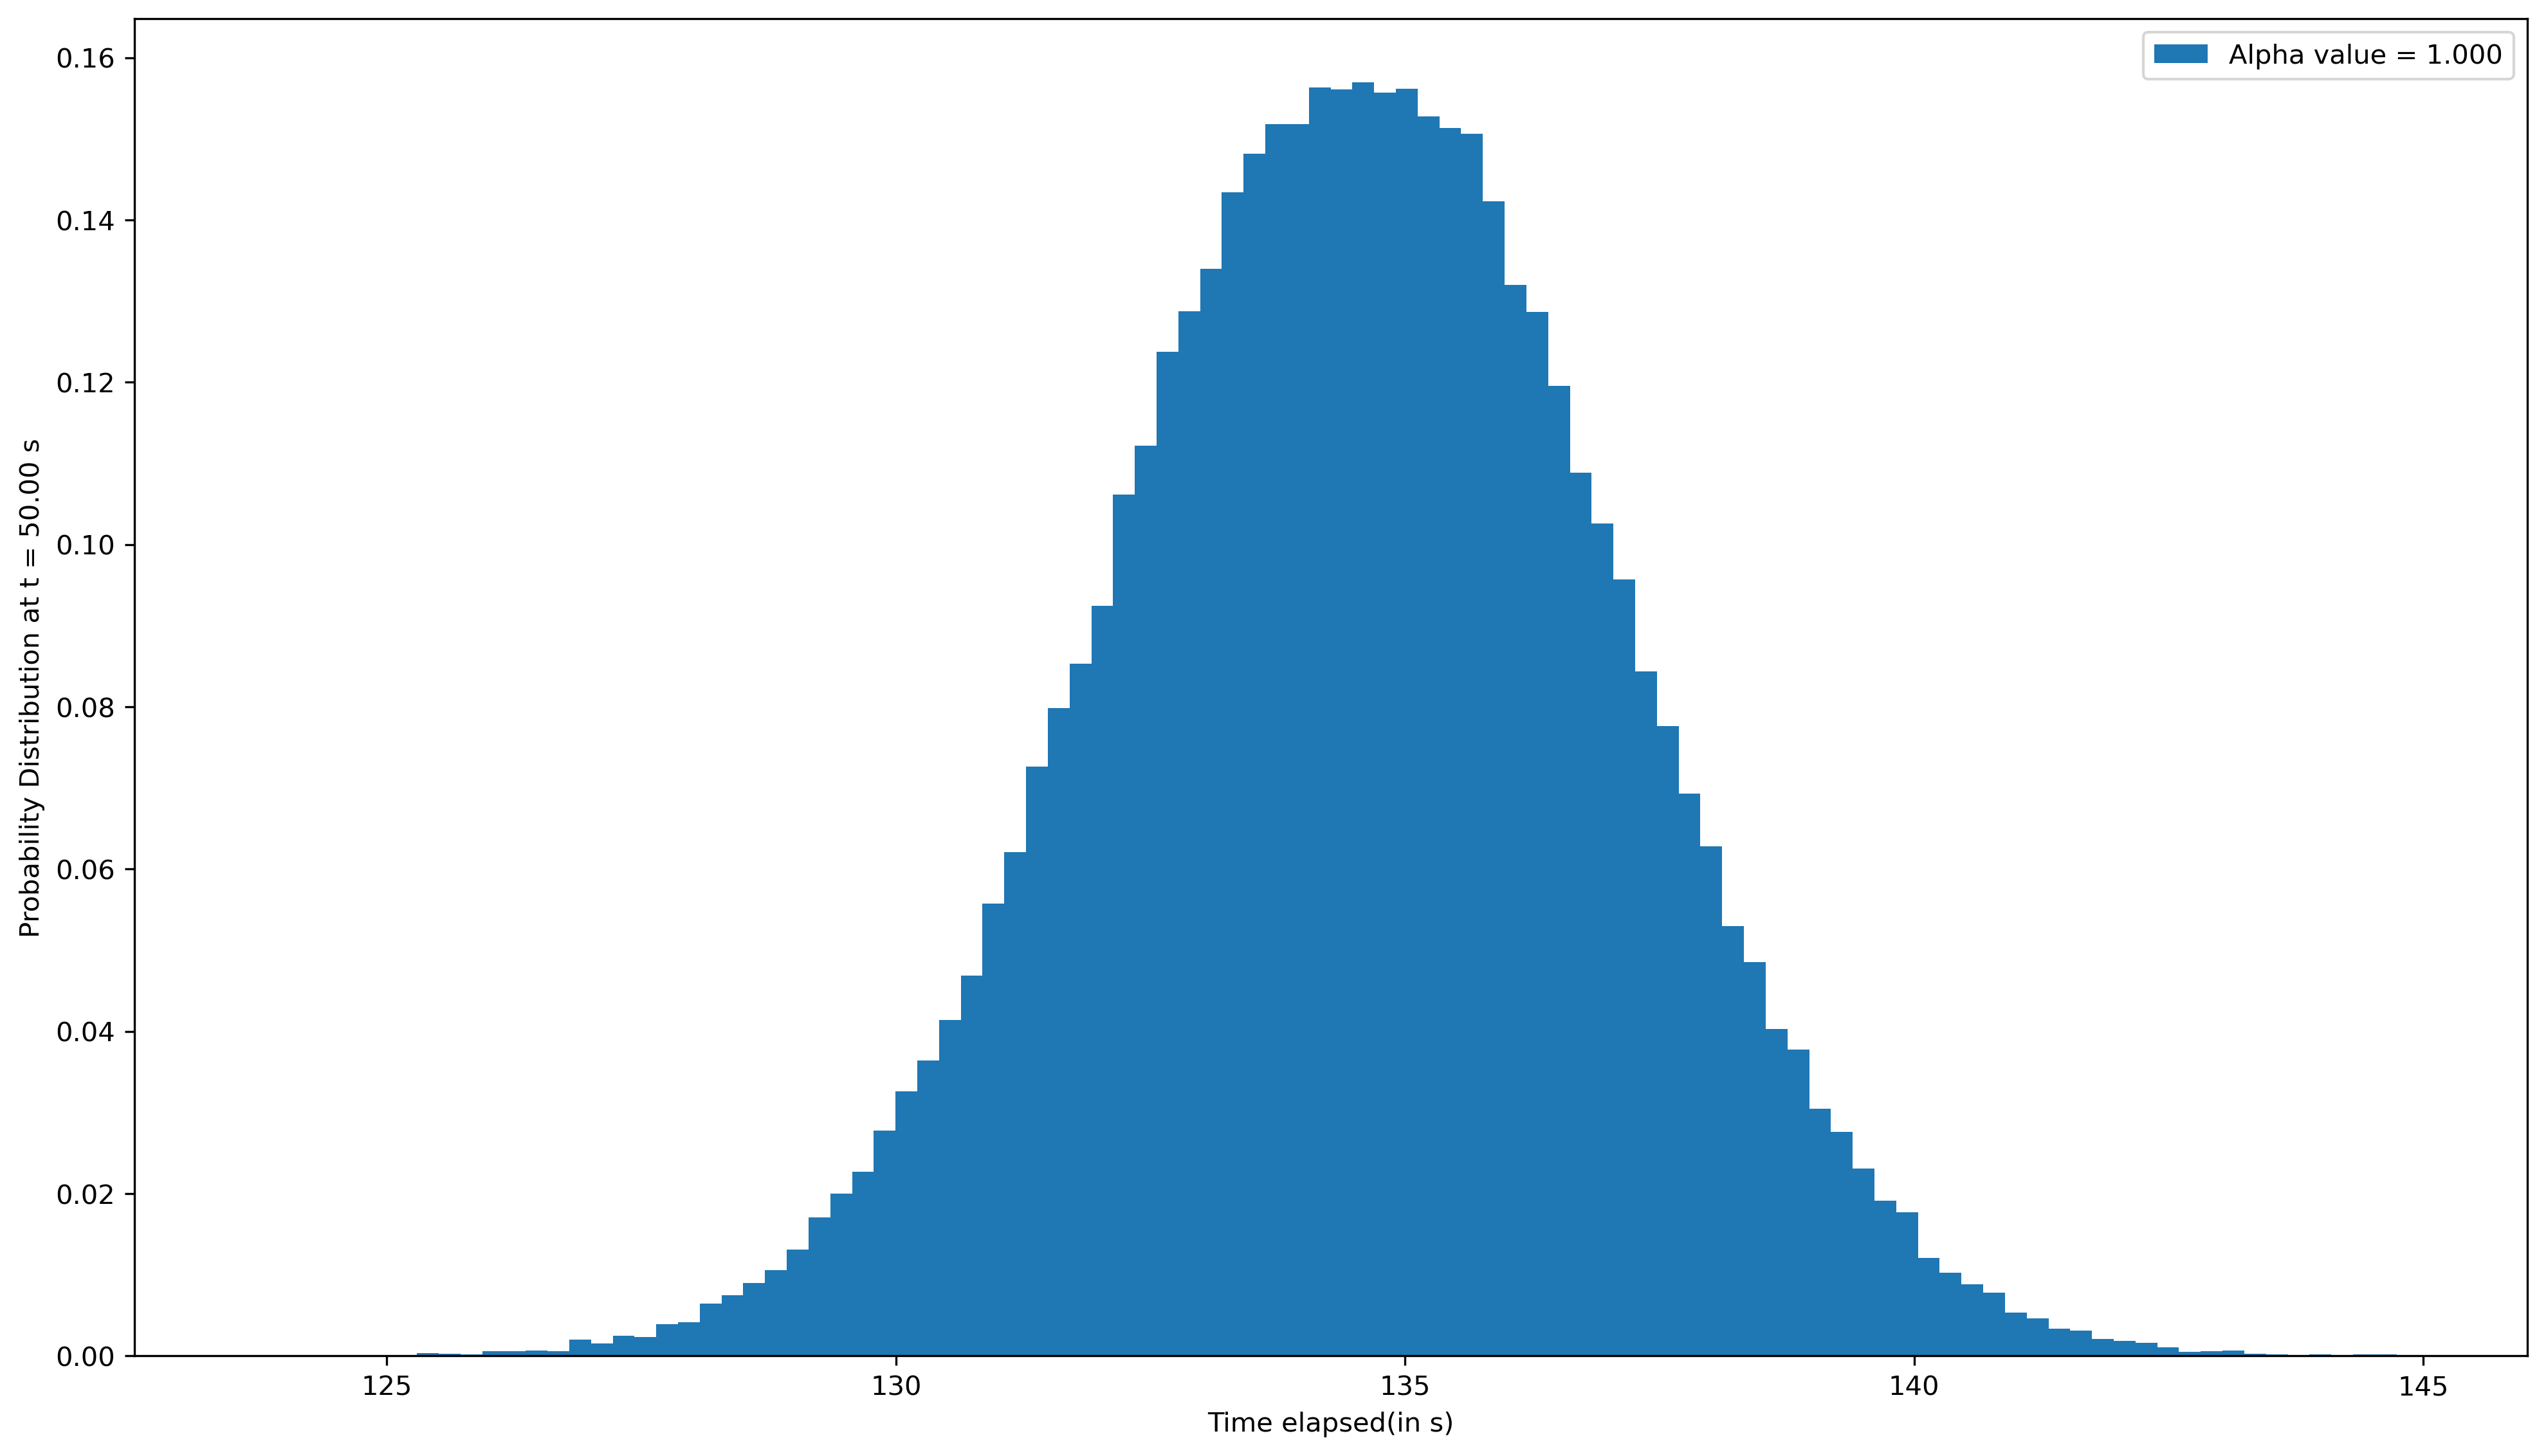

In [60]:
fig,axes = plt.subplots(1,1,figsize=(16,9),dpi=300)
# axes.hist(p_dist_free, bins = 1000, density = True);
# axes.hist(p_dist_pull, bins = 1000, density = True);
for i in range(0,A):
    axes.hist(p_dist[i], bins = 100, density = True, label = f"Alpha value = %.3f"%ALPHA_2[i]);


axes.set_xlabel("Time elapsed(in s)");
axes.set_ylabel("Probability Distribution at t = %.2f s"%t_stamp);
axes.legend()

### Stop Ignoring Cells

## Likelihood Calculation

In [106]:
@jit
def likelihoodcalc(x_coord,DT,D,F,ALPHA):
    PROB = 1
    std_dev = np.zeros(n+1)
    mean_dist = np.zeros(n+1)
    for i in range(1,n+1):
        std_dev[i] = 2 * k_BT * D * (np.abs(x_coord[i-1])**ALPHA) * DT
        mean_dist[i] = x_coord[i-1] + ((np.abs(x_coord[i-1])**ALPHA) * F + k_BT * (ALPHA * D * (np.abs(x_coord[i-1])**(ALPHA-1)*(np.sign(x_coord[i-1])))))* DT
        PROB *= 1/np.sqrt(2 * np.pi * std_dev[i]) * np.exp((-(x_coord[i] - mean_dist[i])**2)/(2 * std_dev[i]))
    return PROB

In [118]:
# def Model(num,t_end,F,D,ALPHA):
N = 10000
PROBX = np.zeros(N)
d_range=np.linspace(0.1,1,N)
t_coord, x_sample = Model(n,t_e,F_L[0],D_0,ALPHA_1)
for i in range(0,N):
    PROBX[i] = likelihoodcalc(x_sample,DT,d_range[i],F_L[0],ALPHA_1)
PROBX

array([2.38099340e-152, 2.62945002e-152, 2.90319753e-152, ...,
       6.02893050e-140, 6.01008310e-140, 5.99129549e-140])

In [122]:
N = 10000
PROBF = np.zeros(N)
p_data = [50,46.743,46.751,40.915,45.066,50.56,44.448,40.518,40.145,39.551,42.887,40.218,44.399,38.416,36.626,35.867,30.252,28.843,26.412,27.815,28.166,32.899,34.738,33.237,24.448,22.771,19.285,24.966,23.912,23.839,23.83,22.253,15.661,20.156,20.166,16.9,15.495,18.734,18.234,17.823,16.052,11.424,9.4223,7.3746,7.2549,7.2847,6.7366,7.7324,6.8572,7.034,5.3564,3.7969,3.4073,4.3653,4.56,4.8884,3.8021,2.9259,3.5701,4.0879,2.3471,0.95298,1.7231,1.7968,1.753,2.1651,2.1354,2.404,2.9188,1.1974,1.3358,1.428,1.8476,2.1991,1.1013,1.3227,0.71634,0.68376,0.89795,1.6167,2.0934,2.4119,1.0693,1.2777,2.2396,0.30283,0.64551,-0.44319,-0.79814,-0.82102,-2.0478,-1.6834,-1.8176,-1.3092,-1.2355,-1.8231,-1.8543,-2.1829,-4.2785,-4.2926]
DT = 1
x_sample = np.array(p_data)
d_range=np.linspace(0.1,1,N)
for i in range(0,N):
    PROBF[i] = likelihoodcalc(x_sample,DT,d_range[i],F_L[2],ALPHA_1)
PROBF

array([1.77700663e-128, 2.02582259e-128, 2.30883715e-128, ...,
       2.94110977e-105, 2.93061926e-105, 2.92016642e-105])

In [100]:
@jit
def GaussianLikelihood(x_coord, DT, D, F, ALPHA):
    PROB = 1
    std_dev = np.zeros(n+1)
    mean_dist = np.zeros(n+1)
    for i in range(1,n+1):
        std_dev[i] = 2 * k_BT * D * (np.abs(x_coord[i-1])**ALPHA) * DT
        mean_dist[i] = x_coord[i-1]
        # mean_dist[i] = x_coord[i-1] + ((np.abs(x_coord[i-1])**ALPHA) * F + k_BT * (ALPHA * D * ((np.abs(x_coord[i-1])**(ALPHA-1)*(x_coord[i-1]/(np.abs(x_coord[i-1])))))))* DT
        PROB *= 1/np.sqrt(2 * np.pi * std_dev[i]) * np.exp((-(x_coord[i] - mean_dist[i])**2)/(2 * std_dev[i]))
    return PROB

In [101]:
N = 10000
PROBY = np.zeros(N)
d_range_2=np.linspace(0.1,1,N)
for i in range(0,N):
    t_coord, x_sample = Model(n,t_e,F_L[0],d_range[i],ALPHA_1)
    PROBY[i] = GaussianLikelihood(x_sample,DT,d_range_2[i],F_L[0],ALPHA_1)
PROBY

array([8.45268888e-131, 5.24519450e-128, 1.25801540e-119, ...,
       1.59718538e-177, 2.87707778e-184, 5.45965386e-180])

In [102]:
loglikelihood = np.log(PROBX)
loglikelihood2 = np.log(PROBY)

/tmp/ipykernel_169524/3617112275.py:1: RuntimeWarning: divide by zero encountered in log
  loglikelihood = np.log(PROBX)
/tmp/ipykernel_169524/3617112275.py:2: RuntimeWarning: divide by zero encountered in log
  loglikelihood2 = np.log(PROBY)


In [92]:
np.log(PROBX[0])

-263.0395388654033

In [88]:
loglikelihood

array([-263.03953887, -475.826471  , -355.61584695, ..., -476.6198864 ,
       -437.19901623, -447.259307  ])

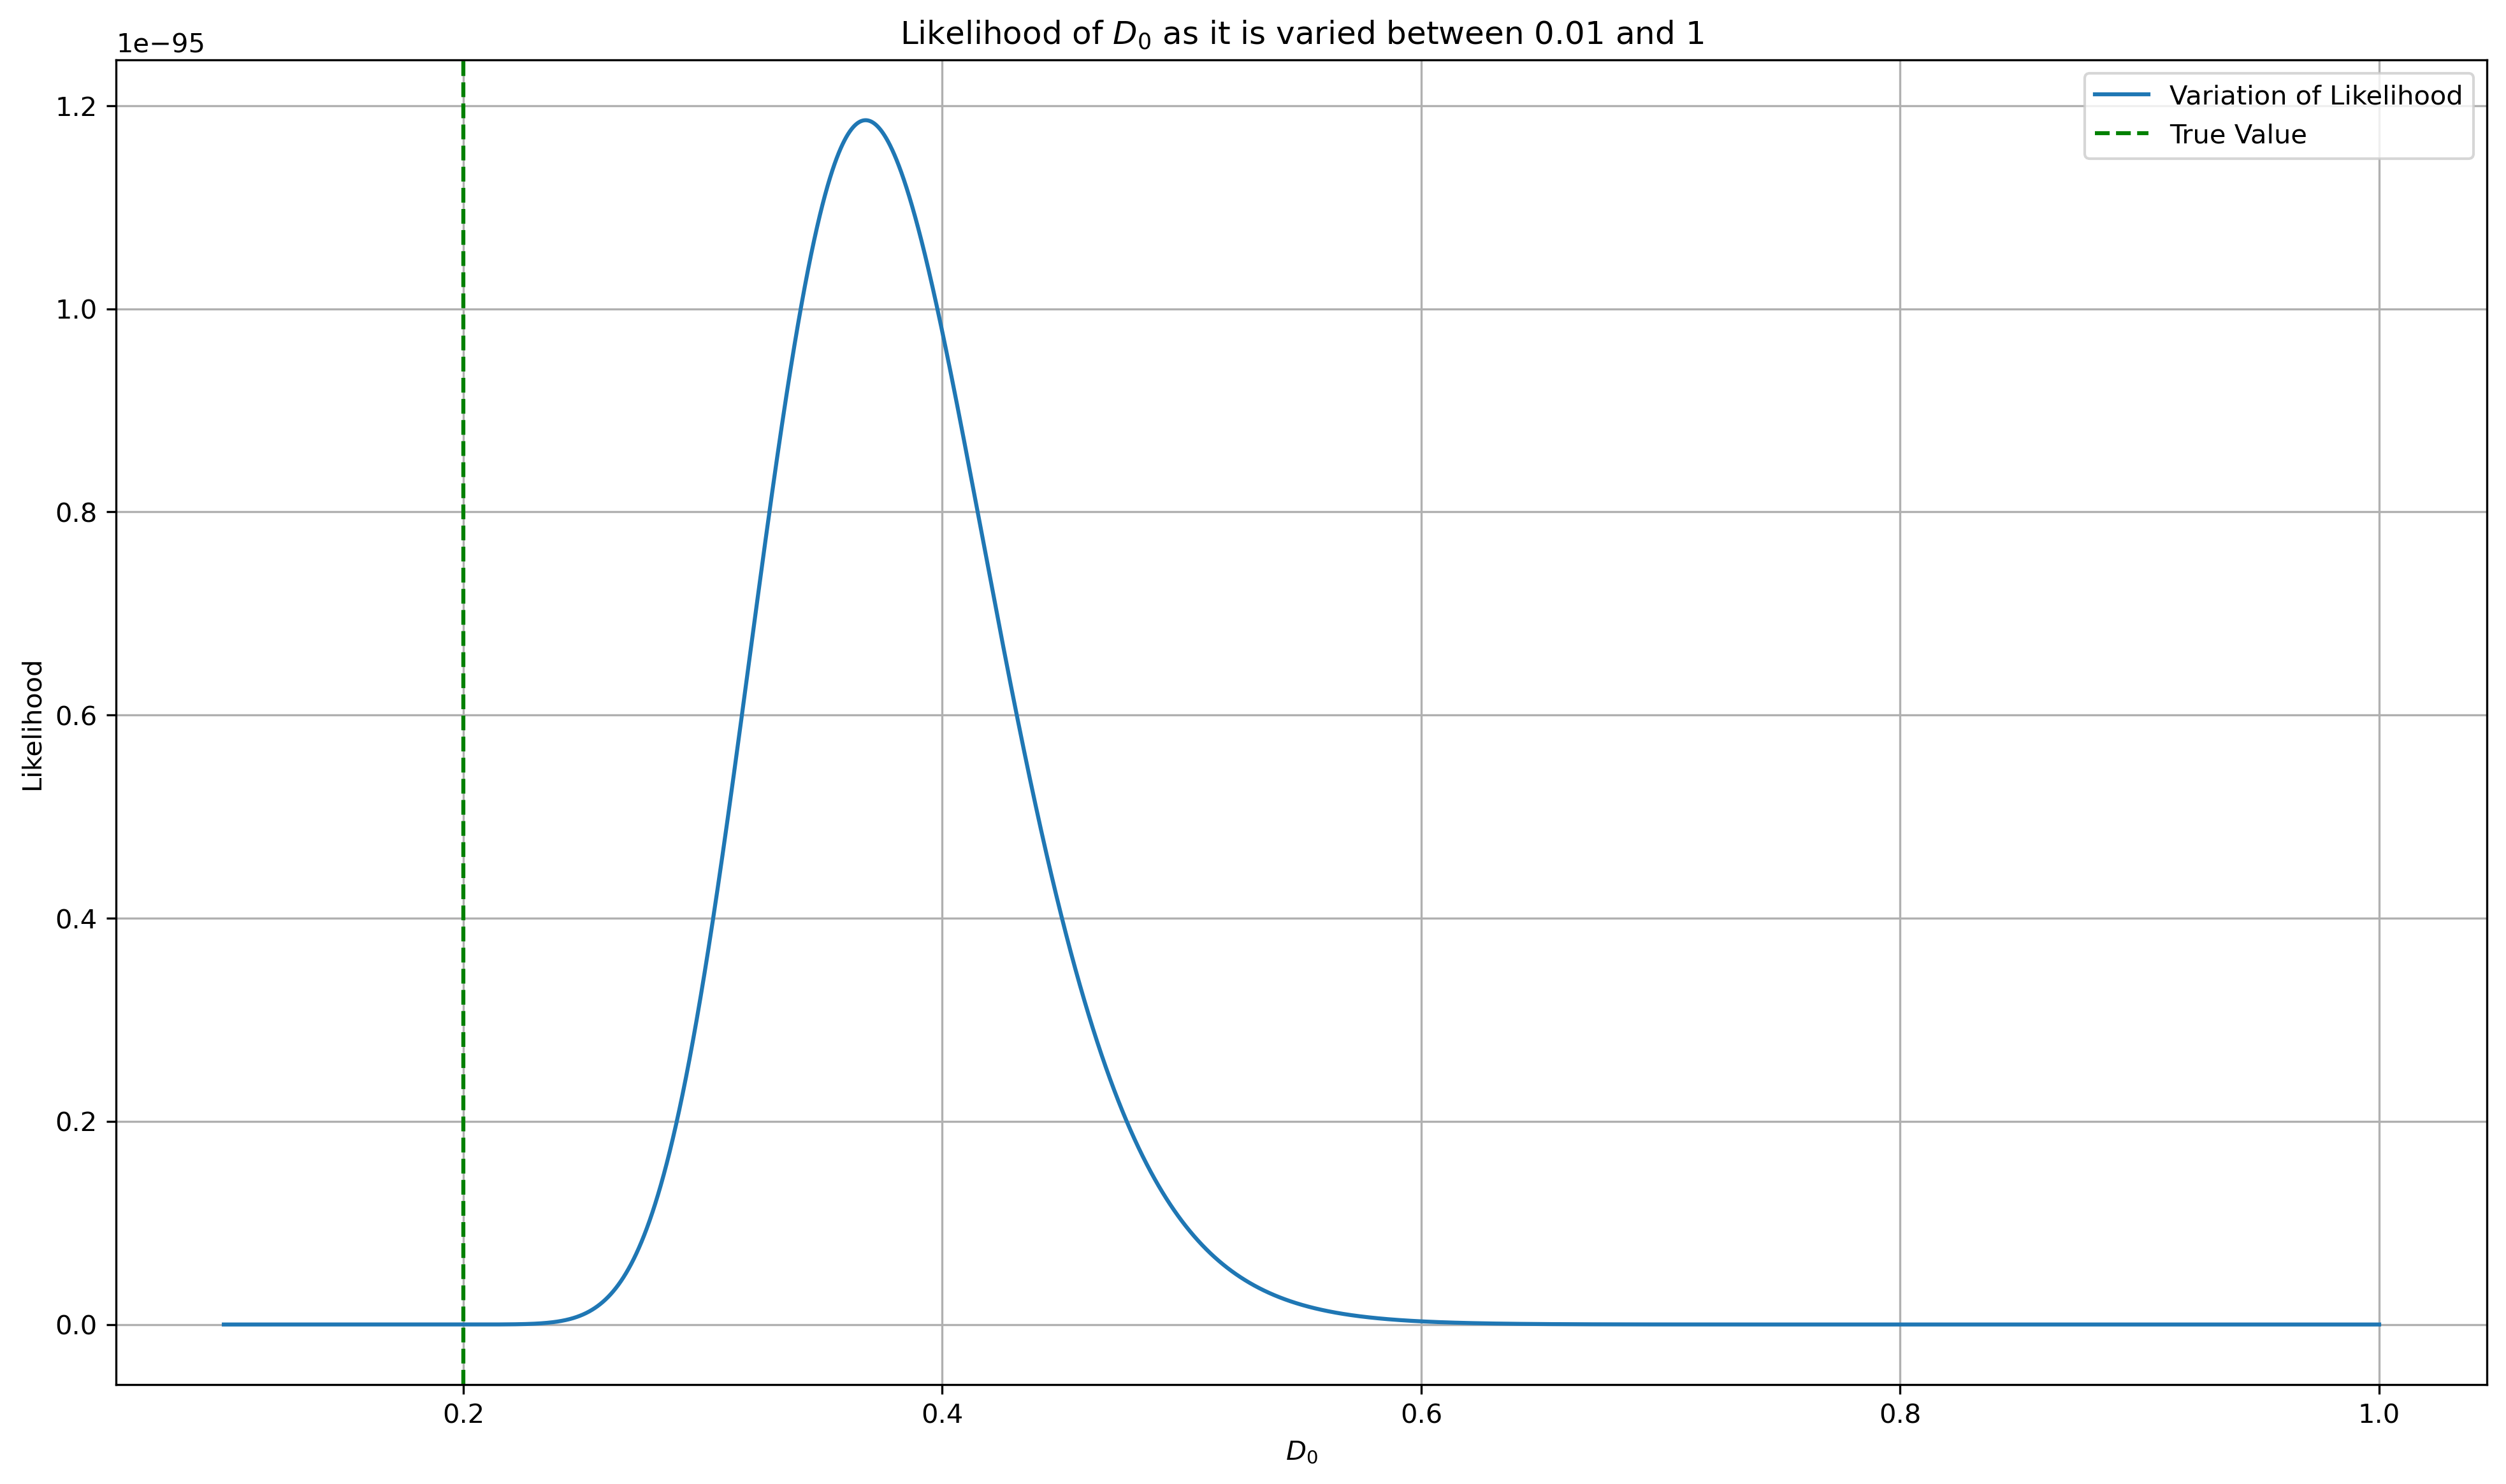

In [123]:
fig, axes = plt.subplots(1, 1, figsize = (16, 9), dpi = 300)
axes.plot(d_range,PROBF,label="Variation of Likelihood")
axes.set_xlabel(r"$D_0$")
axes.set_ylabel("Likelihood")
# axes.set_xlim((0,1))
# axes.set_ylim(bottom = 0)

axes.axvline(x=0.2,ls = '--', color = 'g',label="True Value")
axes.legend()
axes.set_title(r"Likelihood of $D_0$ as it is varied between 0.01 and 1")
axes.grid()
fig.savefig("loglikelihood")

## The ftrack data from the github repo

In [90]:
p_data = [50,46.743,46.751,40.915,45.066,50.56,44.448,40.518,40.145,39.551,42.887,40.218,44.399,38.416,36.626,35.867,30.252,28.843,26.412,27.815,28.166,32.899,34.738,33.237,24.448,22.771,19.285,24.966,23.912,23.839,23.83,22.253,15.661,20.156,20.166,16.9,15.495,18.734,18.234,17.823,16.052,11.424,9.4223,7.3746,7.2549,7.2847,6.7366,7.7324,6.8572,7.034,5.3564,3.7969,3.4073,4.3653,4.56,4.8884,3.8021,2.9259,3.5701,4.0879,2.3471,0.95298,1.7231,1.7968,1.753,2.1651,2.1354,2.404,2.9188,1.1974,1.3358,1.428,1.8476,2.1991,1.1013,1.3227,0.71634,0.68376,0.89795,1.6167,2.0934,2.4119,1.0693,1.2777,2.2396,0.30283,0.64551,-0.44319,-0.79814,-0.82102,-2.0478,-1.6834,-1.8176,-1.3092,-1.2355,-1.8231,-1.8543,-2.1829,-4.2785,-4.2926]
t_data = np.arange(0,len(p_data))

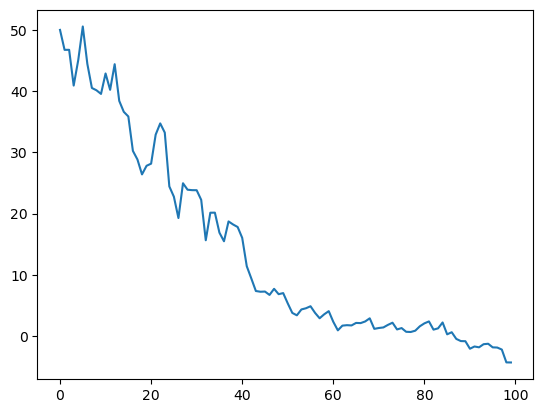

In [229]:
plt.plot(t_data,p_data)

In [104]:
np.sign?

Call signature:  np.sign(*args, **kwargs)
Type:            ufunc
String form:     <ufunc 'sign'>
File:            ~/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/__init__.py
Docstring:      
sign(x, /, out=None, *, where=True, casting='same_kind', order='K', dtype=None, subok=True[, signature, extobj])

Returns an element-wise indication of the sign of a number.

The `sign` function returns ``-1 if x < 0, 0 if x==0, 1 if x > 0``.  nan
is returned for nan inputs.

For complex inputs, the `sign` function returns
``sign(x.real) + 0j if x.real != 0 else sign(x.imag) + 0j``.

complex(nan, 0) is returned for complex nan inputs.

Parameters
----------
x : array_like
    Input values.
out : ndarray, None, or tuple of ndarray and None, optional
    A location into which the result is stored. If provided, it must have
    a shape that the inputs broadcast to. If not provided or None,
    a freshly-allocated array is returned. A tuple (possible only as a
    keyword argument) must ha

# The cells below are irrevalent, pls ignore

In [43]:
X = np.linspace(-20,20,1000)

# Gaussian Distribution
norm = stats.norm

# fitting the histogram with the gaussian dist
param = norm.fit(p_t_stamp,floc=0) # floc fixes the the average to be 0
pdf_fit = norm.pdf(X,*param)


# the standard deviation from the derived equation
sigma = np.sqrt((D/LAMBDA) * (1 - np.exp((-2) * LAMBDA * t_stamp))) 
pdf_eq = norm.pdf(X,0,sigma)

NameError: name 'p_t_stamp' is not defined

The Probability Distribution from the Fokker Planck Dist is given by 

$$ \boxed{P(x,t) \sim Normal(0, \frac{D}{\lambda}[1-e^{-2\lambda t}])} $$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


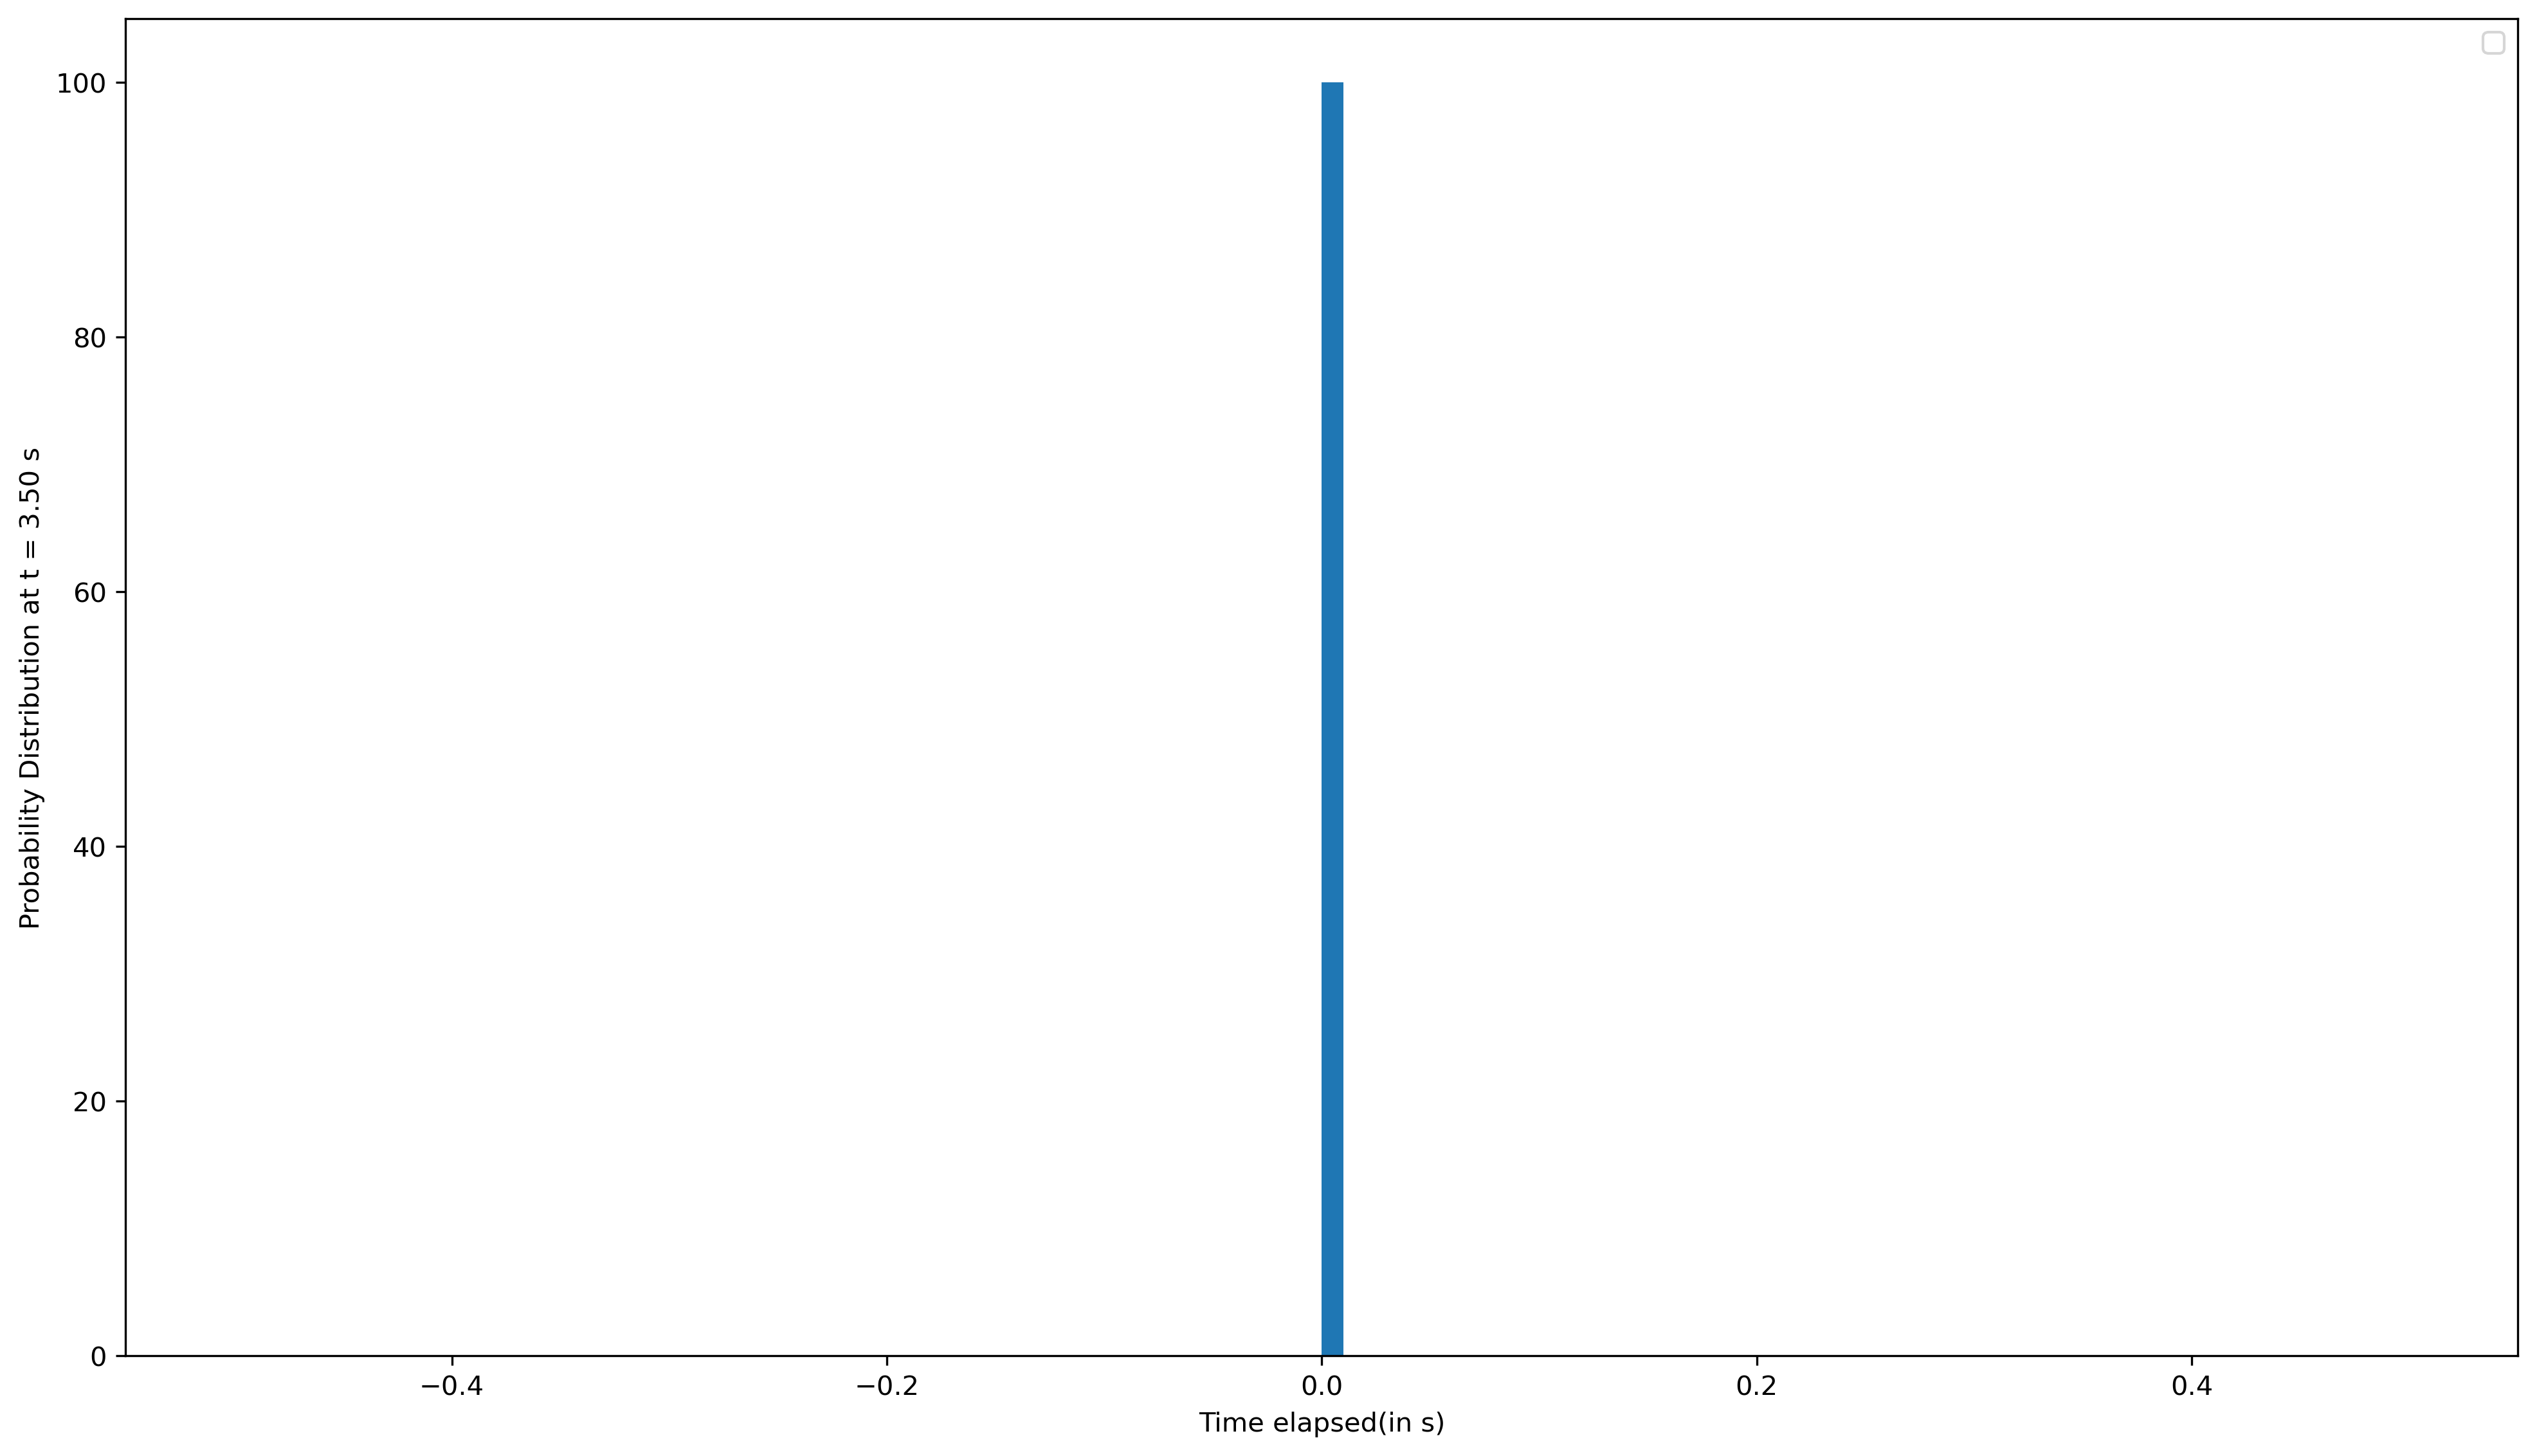

In [78]:
fig,axes = plt.subplots(1,1,figsize=(16,9),dpi=300)
axes.hist(p_t_stamp, bins = 100, density = True);
axes.set_xlabel("Time elapsed(in s)")
axes.set_ylabel("Probability Distribution at t = %.2f s"%t_stamp)
# axes.plot(X,pdf_fit,lw=5,label=rf"scipy.stats.fit with $\mu$ = %.1f, $sigma$ = %.5f"%(param[0],param[1]))
# axes.plot(X,pdf_eq,label=rf"$\sigma$ = %0.4f derived from the equation "%sigma)
axes.legend()